---
title: "Fine-Tining Kodis"
author: "Michelle Gelman"
date: "04/30/2025"
format: 
  html:
    code-fold: true
    toc: true
    execute:
      eval: false
      echo: True
      cache: True
jupyter: python3
---


# Notes
- According to craft paper, only context prior to derailment comment is used in training. 
    - "Note that by construction, the last comment of each conversation is the one marked as derailment, and that our earlier code was therefore set up to not look at the last comment, meaning that all forecasts we obtained are forecasts made prior to derailment. This simplifies the computation of forecast accuracy as we now do not need to explicitly consider when a forecast was made." 
    - [Reproducible code for CMV data](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH#scrollTo=FYxW_AuWszqX)
    - [Reproducible code for WIKI data (fine-tuning + inference)](https://github.com/jpwchang/CRAFT/blob/main/fine_tuning_demo.ipynb)
    - [New Forecaster Framework says to follow training on last_only context tuple (all commens up to final)](https://github.com/CornellNLP/ConvoKit/blob/master/examples/forecaster/CRAFT%20Forecaster%20demo.ipynb)
    - Claim all samples in train/val set for CMV/WIKI use "last only" context (entire convo up to last comment) for training-- therefor assume that last comment has the derailed event in train set. **However, my plot for utterances after derailment comment for wiki test set says otherwise? There are comments after the derailment comment in test set**
    - In Horizon paper, explicity stated "  if cₑ is the first toxic utterance at index e, we generate tuples for n=1…e–1 otherwise (a non-derailing convo), for n=1…N–1. Only WIKI was annotated at comment using "comment_has_personal_attack" meta data for each utterance.
    - Can we assume that an "impasse" is a derailed conversation?
# Main Resources to Consider
- [Paper on experiements in 2022 to de-escalate convo by intervention to inform users of tension (same authors as Horizon)](https://www.cs.cornell.edu/~cristian/Thread_With_Caution.html)
- [Jonathan Change PhD Thesis on Conversational Forecasting, "TOWARDS COMPUTATIONAL METHODS FOR
PROACTIVELY SUPPORTING HEALTHIER
ONLINE DISCUSSIONS"](https://www.cs.cornell.edu/~cristian/papers/chang_thesis.pdf)
# Todo:
- [ ] A [paper](https://arxiv.org/pdf/1805.05345) from paper from Jonathan P. Cheng (Horizon paper) that preceeeds the CRAFT model defines pragmatic devices—such as politeness strategies and rhetorical prompts—used to start a conversation, and analyze their relation to its future trajectory.
    - [ ] Convokit has a [notebook](https://github.com/CornellNLP/ConvoKit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb) (very recent-2025) that creates Prompt Types/politeness strategy labels for paired utterances to make derailement predicitons
- [ ] Plot utterances frequenices across context length dimension (averaged across all conversations)

# Corpus Pre-processing

In [46]:
%%capture
from tqdm import tqdm
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp
import torch
import pickle
import random
from pathlib import Path 
import json

# Add the src directory to the path
import sys
import os

# Add the src
sys.path.append(os.path.abspath("."))
import import_ipynb

#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster
from convokit import download
from convokit.convokitConfig import ConvoKitConfig

from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp

### Corpus Imports

In [2]:
from convokit import download, Corpus, Forecaster, CRAFTModel
from functools import partial

In [ ]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

In [61]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
filepath_no_last = '/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convos_exclude_last_utt.csv'
filepath_no_submit_last = '/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convos_exclude_submit_and_last.csv'

results_filepath_no_samp = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling/")
results_filepath_no_samp_weighted = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling_weighted/")
results_filepath_downsampled = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled/")

final_data = DataPreprocesser(filepath)
final_data_no_last = DataPreprocesser(filepath_no_last)
final_data_no_submit_last = DataPreprocesser(filepath_no_submit_last)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def makeCleanCorpora():
    final_data = DataPreprocesser(filepath)
    final_data_no_last = DataPreprocesser(filepath_no_last)
    final_data_no_submit_last = DataPreprocesser(filepath_no_submit_last)

    corpus_kodis_ground = corp.corpusBuilder(final_data)
    corpus_kodis_no_last = corp.corpusBuilder(final_data_no_last)
    corpus_kodis_no_submit_last = corp.corpusBuilder(final_data_no_submit_last)

    return corpus_kodis_ground, corpus_kodis_no_last, corpus_kodis_no_submit_last
corpus_kodis_ground, corpus_kodis_no_last, corpus_kodis_no_submit_last = makeCleanCorpora()

display(corpus_kodis_ground.get_utterances_dataframe())
display(corpus_kodis_no_last.get_utterances_dataframe())
display(corpus_kodis_no_submit_last.get_utterances_dataframe())

Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'
27498it [00:00, 67649.43it/s]
25391it [00:00, 66968.19it/s]
23117it [00:00, 70699.83it/s]


,timestamp,text,speaker,reply_to,conversation_id,vectors
id,,,,,,
utt0_con1,1699388451,Hi there! I believe I received the wrong jerse...,Buyer_1,None,utt0_con1,[]
utt1_con1,1699388553,Good afternoon! I looked over your purchase re...,Seller_1,utt0_con1,utt0_con1,[]
utt2_con1,1699388719,I appreciate your timely response! I can under...,Buyer_1,utt1_con1,utt0_con1,[]
utt3_con1,1699388896,Of course! We try to reach all our customers a...,Seller_1,utt2_con1,utt0_con1,[]
utt4_con1,1699389108,"I can return the generic jersey, no problem! I...",Buyer_1,utt3_con1,utt0_con1,[]
...,...,...,...,...,...,...
utt6_con2880,1718879513,"Cool no problem, so just to clarify, you will ...",Buyer_2880,utt5_con2880,utt0_con2880,[]
utt7_con2880,1718879641,I will refund you after you have sent the item...,Seller_2880,utt6_con2880,utt0_con2880,[]
utt8_con2880,1718879680,"Great thanks for this outcome, enjoy the rest ...",Buyer_2880,utt7_con2880,utt0_con2880,[]


,timestamp,text,speaker,reply_to,conversation_id,vectors
id,,,,,,
utt0_con1,1699388451,Hi there! I believe I received the wrong jerse...,Buyer_1,None,utt0_con1,[]
utt1_con1,1699388553,Good afternoon! I looked over your purchase re...,Seller_1,utt0_con1,utt0_con1,[]
utt2_con1,1699388719,I appreciate your timely response! I can under...,Buyer_1,utt1_con1,utt0_con1,[]
utt3_con1,1699388896,Of course! We try to reach all our customers a...,Seller_1,utt2_con1,utt0_con1,[]
utt4_con1,1699389108,"I can return the generic jersey, no problem! I...",Buyer_1,utt3_con1,utt0_con1,[]
...,...,...,...,...,...,...
utt5_con2880,1718879412,No problem. It happens sometimes. It will be a...,Seller_2880,utt4_con2880,utt0_con2880,[]
utt6_con2880,1718879513,"Cool no problem, so just to clarify, you will ...",Buyer_2880,utt5_con2880,utt0_con2880,[]
utt7_con2880,1718879641,I will refund you after you have sent the item...,Seller_2880,utt6_con2880,utt0_con2880,[]


,timestamp,text,speaker,reply_to,conversation_id,vectors
id,,,,,,
utt0_con1,1699388451,Hi there! I believe I received the wrong jerse...,Buyer_1,None,utt0_con1,[]
utt1_con1,1699388553,Good afternoon! I looked over your purchase re...,Seller_1,utt0_con1,utt0_con1,[]
utt2_con1,1699388719,I appreciate your timely response! I can under...,Buyer_1,utt1_con1,utt0_con1,[]
utt3_con1,1699388896,Of course! We try to reach all our customers a...,Seller_1,utt2_con1,utt0_con1,[]
utt4_con1,1699389108,"I can return the generic jersey, no problem! I...",Buyer_1,utt3_con1,utt0_con1,[]
...,...,...,...,...,...,...
utt4_con2880,1718879295,"This is great thank you, I apologise too if I ...",Buyer_2880,utt3_con2880,utt0_con2880,[]
utt5_con2880,1718879412,No problem. It happens sometimes. It will be a...,Seller_2880,utt4_con2880,utt0_con2880,[]
utt6_con2880,1718879513,"Cool no problem, so just to clarify, you will ...",Buyer_2880,utt5_con2880,utt0_con2880,[]


### Adding Conversation Labels

In [63]:
def add_convo_labels(corpus, final_data):
    for idx, row in final_data.getDataframe().iterrows():
        convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
        label = row["dispute_outcome"]  # update if your label column is named differently
        if convo_id in corpus.conversations:
            corpus.get_conversation(convo_id).meta["label"] = label

In [64]:
add_convo_labels(corpus_kodis_ground, final_data)
add_convo_labels(corpus_kodis_no_last, final_data_no_last)
add_convo_labels(corpus_kodis_no_submit_last, final_data_no_submit_last)


### Tagging final utterances and Submit agreement

In [9]:
from convokit import Corpus

# load your corpus however you normally do:
# e.g. corpus = Corpus("path/to/my/corpus")

def exclude_utt(corpus, submit, last):
    for conv in corpus.iter_conversations():  
        # grab utterances in chronological order
        uts = conv.get_chronological_utterance_list()
        last_utt_id = uts[-1].id if uts else None

        # loop through all utterances in the conversation
        for utt in conv.iter_utterances():
            # set exclude=True if it's the last utt or contains "Submitted agreement"
            if utt.id == last_utt_id:
                utt.add_meta("exclude", last)
            if "Submitted agreement" in utt.text:
                utt.add_meta("exclude", submit)
            # otherwise explicitly set exclude=False
            else:
                utt.add_meta("exclude", False)

### Weighted Model Class

In [ ]:

class CostSensitiveCRAFTModel(CRAFTModel):

    def fit(self, contexts, val_contexts=None):

        '''Count nuber of positive and negative labels in the training set of context tuples fed into CRAFTModel.'''
        train_pairs = list(self._context_to_craft_data(contexts))
        labels      = [label for (_ctx, _utt, label, _id) in train_pairs]
        num_pos     = sum(labels)
        num_neg     = len(labels) - num_pos

        # 1b) compute pos_weight = (#neg)/(#pos)
        self._pos_weight = torch.tensor(num_neg/num_pos, device=self._device)

        # 1c) hand back a *fresh* iterator into the superclass
        def replay_iter():
            for pair in train_pairs:
                yield pair

                
        # AND rebuild the val iterator the normal way
        super_contexts = replay_iter()
        super_val_ctxs = None
        if val_contexts is not None:
            super_val_ctxs = self._context_to_craft_data(val_contexts)
        return super().fit(super_contexts, super_val_ctxs)

    def _init_craft(self):
        # build the usual encoder/context/classifier
        embedding, encoder, context_encoder, attack_clf = super()._init_craft()
        '''adding pre-computing weight for penalizing false negatives more'''
        attack_clf.pos_weight = self._pos_weight
        return embedding, encoder, context_encoder, attack_clf
    


ModuleNotFoundError: No module named 'convokit.forecaster.CRAFT.CRAFTModel'

### Generating All Models

In [38]:

DEVICE = "cuda"
cfg = ConvoKitConfig()
download_dir = cfg.model_directory
base_path = download("craft-wiki-pretrained", data_dir=download_dir)


In [ ]:
model_ground_default = CRAFTModel(
    model_path=base_path,
    device=DEVICE
)

model_no_last_default = CRAFTModel(
    model_path=base_path,
    device=DEVICE
)

model_no_submit_last_default = CRAFTModel(
    model_path=base_path,
    device=DEVICE
)
model_ground_weighted = CostSensitiveCRAFTModel(
    model_path=base_path,
    device=DEVICE
)
model_no_last_weighted = CostSensitiveCRAFTModel(
    model_path=base_path,
    device=DEVICE
)
model_no_submit_last_weighted = CostSensitiveCRAFTModel(
    model_path=base_path,
    device=DEVICE
)

model_ground_downsampled = CRAFTModel(
    model_path=base_path,
    device=DEVICE,
    downsampled=True
)
model_no_last_downsampled = CRAFTModel(
    model_path=base_path,
    device=DEVICE,
    downsampled=True
)
model_no_submit_last_downsampled = CRAFTModel(
    model_path=base_path,
    device=DEVICE,
    downsampled=True
)

# Splitting KODIS: Training/Test Set

In [13]:
import random

def corpus_train_test_split(corpus):

    # Set random seed for reproducibility
    random.seed(42)

    # 1. Get all conversation IDs
    all_convo_ids = list(corpus.get_conversation_ids())

    # 2. Shuffle the conversation IDs
    random.shuffle(all_convo_ids)

    # 3. Define proportions
    n_total = len(all_convo_ids)
    n_train = int(0.7 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val  # ensures 100% total

    # 4. Split into train/val/test
    train_convos = all_convo_ids[:n_train]
    val_convos = all_convo_ids[n_train:n_train+n_val]
    test_convos = all_convo_ids[n_train+n_val:]


    # 5. Mark conversations with a split tag
    for convo_id in train_convos:
        corpus.get_conversation(convo_id).meta["split"] = "train"
    for convo_id in val_convos:
        corpus.get_conversation(convo_id).meta["split"] = "val"
    for convo_id in test_convos:
        corpus.get_conversation(convo_id).meta["split"] = "test"


In [14]:
corpus_train_test_split(corpus_kodis_ground)
corpus_train_test_split(corpus_kodis_no_last)
corpus_train_test_split(corpus_kodis_no_submit_last)

### Testing Train/Test split

In [16]:
import random

# Function to get a random conversation from a split
def sample_random_convo(corpus, split_name):
    # Filter conversations by split
    split_convos = [c for c in corpus.iter_conversations() if c.meta.get("split") == split_name]
    # Choose a random one
    return random.choice(split_convos)

# Sample and print
train_sample = sample_random_convo(corpus_kodis_ground, "train")
val_sample = sample_random_convo(corpus_kodis_ground, "val")
test_sample = sample_random_convo(corpus_kodis_ground, "test")

print("--- Random Train Conversation ---")
print(train_sample.get_chronological_utterance_list())

print("\n--- Random Validation Conversation ---")
print(val_sample.get_chronological_utterance_list())

print("\n--- Random Test Conversation ---")
print(test_sample.get_chronological_utterance_list())


--- Random Train Conversation ---
[Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Buyer_1030', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x154b0ba10>, 'id': 'utt0_con1030', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Seller_1030', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x154b0ba10>, 'id': 'utt1_con1030', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Buyer_1030', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x154b0ba10>, 'id': 'utt2_con1030', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'spe

### Context Tuple Selector

In [ ]:
def fit_selector(context_tuple, split):
    """
    Select only contexts in the given split, at the end of the conversation,
    and skip any utterance that’s been tagged exclude=True.
    """
    # only keep the desired split
    matches_split = (
        context_tuple.current_utterance
            .get_conversation()
            .meta["split"]
        == split
    )
    # only keep the final context in each convo
    is_end = (len(context_tuple.future_context) == 0)
    # # skip if the current utterance was marked exclude=True
    # not_excluded = not context_tuple.current_utterance.meta.get("exclude", False)

    return matches_split and is_end 

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")

# Finetuning- No Imbalance Correction

### Forecaster Model Creation

In [ ]:
forecaster_kodis_ground = Forecaster(
    forecaster_model=model_ground_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit = Forecaster(
    forecaster_model=model_no_last_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last = Forecaster(
    forecaster_model=model_no_submit_last_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)


### Fine-tuning all models -- Ground Truth (with I walk Away/Accept Deal), No last Utterance, no submit agreement and last utterance Labels

In [ ]:
forecaster_kodis_ground.fit(
    corpus_kodis_ground, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last.fit(
    corpus_kodis_no_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit.fit(
    corpus_kodis_no_submit_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

# Fine-Tuning: Class Imbalance Handling with Class-Weighted Loss 

### Modifying runners.py code for BCE with weighted loss

In [ ]:
import convokit.forecaster.CRAFT.runners as runners

_original_train = runners.train

"Copied from runner.py"
def _cost_sensitive_train(
    input_variable, dialog_lengths, dialog_lengths_list, utt_lengths,
    batch_indices, dialog_indices, labels,
    encoder, context_encoder, attack_clf,
    encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,
    batch_size, clip, device
):
    
    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)

    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = makeContextEncoderInput(
    utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices
    )

    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths)

    # Calculate loss
    #loss = F.binary_cross_entropy_with_logits(logits, labels)
    "Modified to use BCEWithLogitsLoss"
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=attack_clf.pos_weight)
    loss    = loss_fn(logits, labels)

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()

    return loss.item()

runners.train = _cost_sensitive_train

### Forecaster Model Creation

In [ ]:
forecaster_kodis_ground_weighted_loss = Forecaster(
    forecaster_model= model_ground_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_weighted_loss = Forecaster(
    forecaster_mode= model_no_last_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit_weighted_loss = Forecaster(
    forecaster_model= model_no_submit_last_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Fine-tuning the models with cost-sensitive loss

In [ ]:
forecaster_kodis_ground_weighted_loss.fit(
    corpus_kodis_ground, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_weighted_loss.fit(
    corpus_kodis_no_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit_weighted_loss.fit(
    corpus_kodis_no_submit_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

# Fine-tuning: Downsampling Successful Disputes

### Reset runner.py

In [ ]:
runners.train = _original_train

### Downsampling Logic
- Paper controls for topic and length. Check differences in conversation length from each corpus
- Original fine-tuning size (after crowdsourcing extra long examples in Wiki data): 
    - 4188 conversations total (≈ 2 094 derail + 2 094 clean).
    - Train/dev/test split: 60/20/20 → Train ≈ 2512, Dev ≈ 420, Test ≈ 420

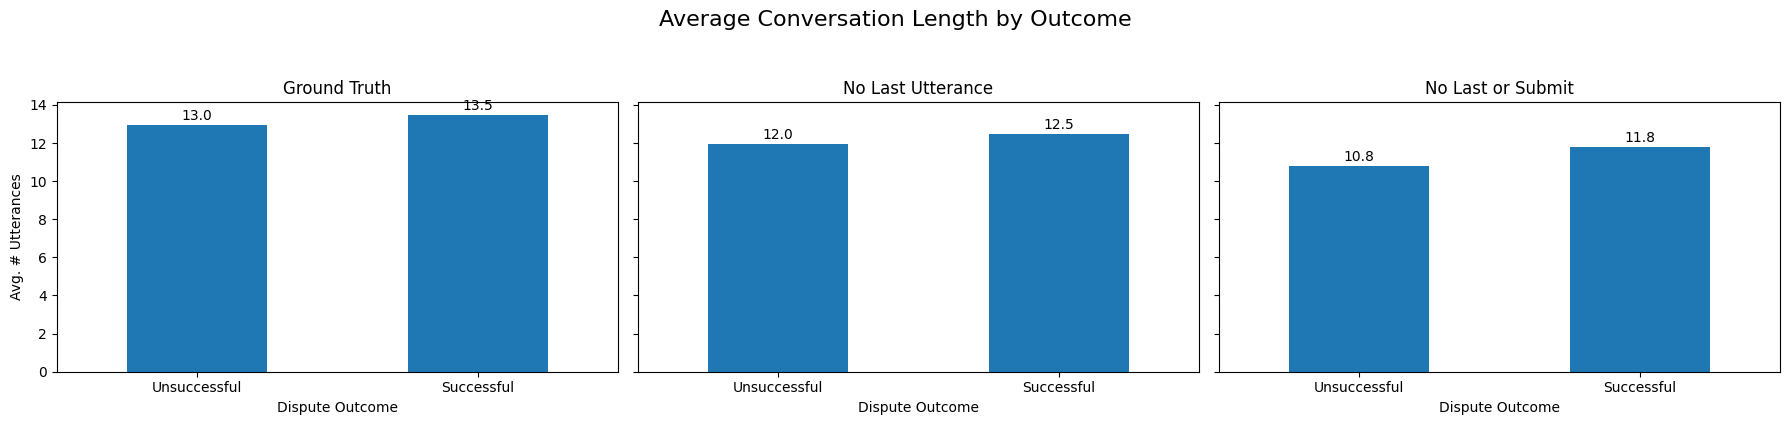

In [18]:
import matplotlib.pyplot as plt

def compare_lengths_side_by_side(corpus_list):
    """
    corpus_list: list of (name:str, corpus) pairs
    Each corpus is assumed to support:
      - corpus.get_utterances_dataframe()
      - corpus.get_conversations_dataframe()
          (which has 'meta.label' column and is indexed by conversation_id)
    """
    n = len(corpus_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4), sharey=True)
    if n == 1:
        axes = [axes]
    for ax, (name, corpus) in zip(axes, corpus_list):
        utts = corpus.get_utterances_dataframe()
        lengths_df = (
            utts
            .groupby("conversation_id")
            .size()
            .reset_index(name="length")
        )
        conv_meta = corpus.get_conversations_dataframe()
        conv_labels = (
            conv_meta
            .reset_index()
            .rename(columns={"id": "conversation_id", "meta.label": "label"})
            [["conversation_id", "label"]]
        )
        merged = lengths_df.merge(conv_labels, on="conversation_id")
        avg_length = (
            merged
            .groupby("label")["length"]
            .mean()
            .rename(index={0: "Unsuccessful", 1: "Successful"})
        )
        bars = avg_length.plot(
            kind="bar",
            rot=0,
            ax=ax,
            title=name
        )
        ax.set_xlabel("Dispute Outcome")
        if ax is axes[0]:
            ax.set_ylabel("Avg. # Utterances")

        # annotate each bar with its height
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,  # x = center of bar
                height + 0.1,                    # a little above the top
                f"{height:.1f}",                 # format with one decimal
                ha="center",
                va="bottom"
            )

    plt.suptitle("Average Conversation Length by Outcome", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

compare_lengths_side_by_side([
    ("Ground Truth", corpus_kodis_ground),
    ("No Last Utterance", corpus_kodis_no_last),
    ("No Last or Submit", corpus_kodis_no_submit_last)
])

### Downsample Successful Conversations

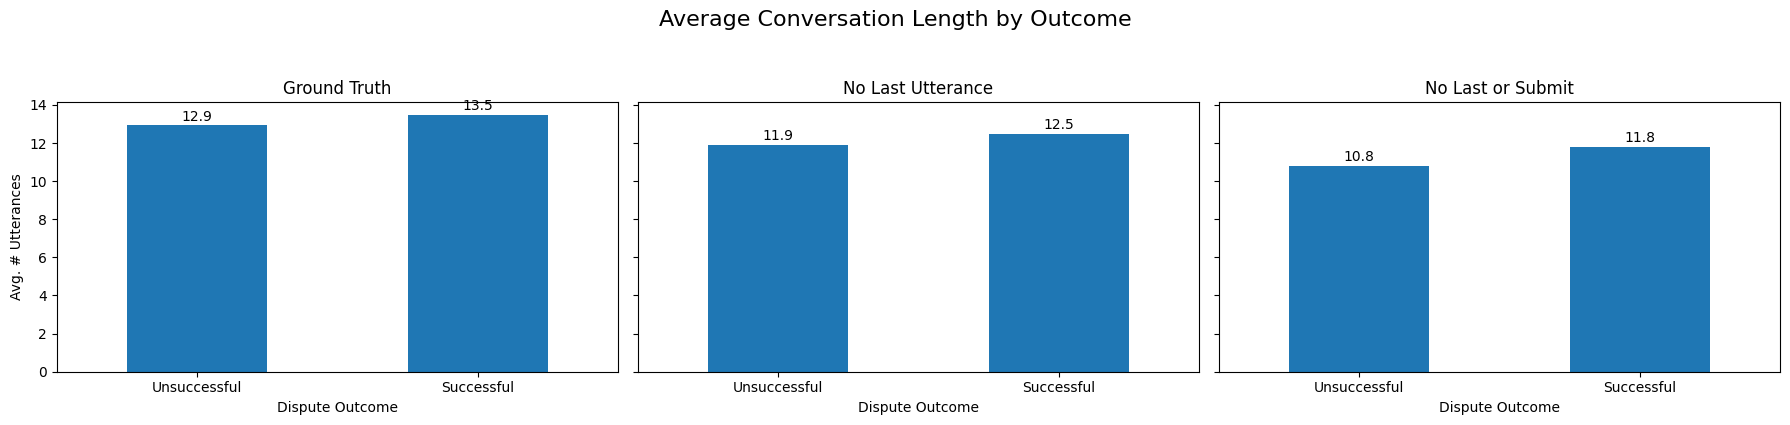

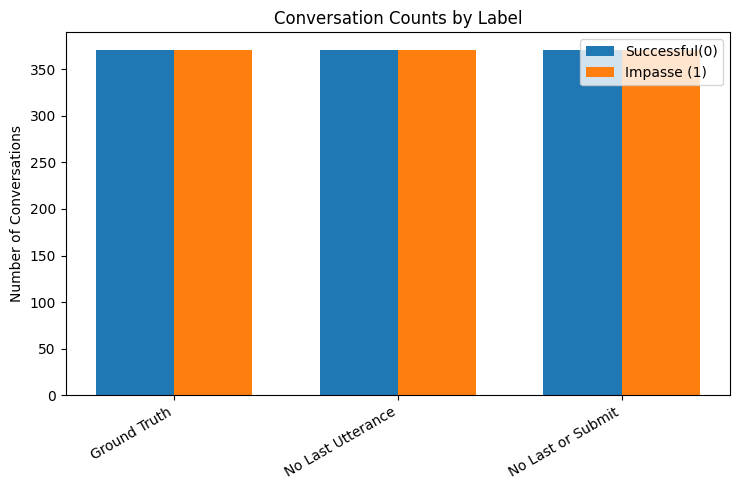

In [ ]:

def downsample_corpus_label(corpus: Corpus, target_label: int, n: int, seed: int = None) -> Corpus:
    """
    Return a corpus where exactly `n` conversations with meta['label']==target_label`
    are kept (randomly sampled), and *all* conversations with the other label are kept.

    :param target_label:  the label value to downsample (e.g. 1)
    :param n:             the exact number of conversations with target_label to keep
    :param seed:          optional random seed for reproducibility
    :returns:             the filtered Corpus
    """
    if seed is not None:
        random.seed(seed)
    convos_by_label = {0: [], 1: []}
    for convo in corpus.iter_conversations():
        lbl = convo.meta.get("label")
        if lbl not in convos_by_label:
            raise ValueError(f"Found conversation with unexpected label {lbl!r}")
        convos_by_label[lbl].append(convo.id)

    total_target = len(convos_by_label[target_label])
    if n > total_target:
        raise ValueError(f"Cannot sample {n} from only {total_target} examples of label {target_label}")

    sampled_target = set(random.sample(convos_by_label[target_label], n))
    other_label = next(lbl for lbl in convos_by_label if lbl != target_label)
    keep_ids = sampled_target.union(convos_by_label[other_label])

    def convo_selector(convo):
        return convo.id in keep_ids
    corpus.filter_conversations_by(convo_selector)
    return corpus

import numpy as np
import matplotlib.pyplot as plt

def plot_corpus_label_counts(corpus_list):
    names = []
    counts_0 = []
    counts_1 = []
    
    for name, corpus in corpus_list:
        names.append(name)
        # extract labels
        labels = [convo.meta.get("label") for convo in corpus.iter_conversations()]
        counts_0.append(sum(1 for l in labels if l == 0))
        counts_1.append(sum(1 for l in labels if l == 1))
    
    # plot
    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6 + len(names)*0.5, 5))
    ax.bar(x - width/2, counts_0, width, label="Unsuccessful (0)")
    ax.bar(x + width/2, counts_1, width, label="Successful (1)")

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=30, ha="right")
    ax.set_ylabel("Number of Conversations")
    ax.set_title("Conversation Counts by Label")
    ax.legend()

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_corpus_label_counts(corpus_list):
    names = []
    counts_0 = []
    counts_1 = []
    
    for name, corpus in corpus_list:
        names.append(name)
        # extract labels
        labels = [convo.meta.get("label") for convo in corpus.iter_conversations()]
        counts_0.append(sum(1 for l in labels if l == 0))
        counts_1.append(sum(1 for l in labels if l == 1))
    
    # plot
    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6 + len(names)*0.5, 5))
    ax.bar(x - width/2, counts_0, width, label="Successful(0)")
    ax.bar(x + width/2, counts_1, width, label="Impasse (1)")

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=30, ha="right")
    ax.set_ylabel("Number of Conversations")
    ax.set_title("Conversation Counts by Label")
    ax.legend()

    plt.tight_layout()
    plt.show()


corpus_kodis_ground_downsampled = downsample_corpus_label(corpus_kodis_ground, target_label=0, n =371, seed=42)
corpus_kodis_no_last_downsampled = downsample_corpus_label(corpus_kodis_no_last, target_label=0, n =371, seed=42)
corpus_kodis_no_submit_last_downsampled = downsample_corpus_label(corpus_kodis_no_submit_last, target_label=0, n =371, seed=42)

corpus_list = [
    ("Ground Truth", corpus_kodis_ground_downsampled),
    ("No Last Utterance", corpus_kodis_no_last_downsampled),
    ("No Last or Submit", corpus_kodis_no_submit_last_downsampled)
]

compare_lengths_side_by_side(corpus_list)
plot_corpus_label_counts(corpus_list)


### Forecaster Model Creation

In [ ]:
forecaster_kodis_ground_downsampled = Forecaster(
    forecaster_model=model_ground_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_downsampled = Forecaster(
    forecaster_model= model_no_last_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit_downsampled = Forecaster(
    forecaster_model= model_no_submit_last_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Fine-tuning Models with Downsampling

In [ ]:
forecaster_kodis_ground_downsampled.fit(
    corpus_kodis_ground, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_downsampled.fit(
    corpus_kodis_no_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit_downsampled.fit(
    corpus_kodis_no_submit_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

# Testing Fine-tuned Craft Models

### No sampling Correction

In [ ]:
corpus_kodis_ground = forecaster_kodis_ground.transform(corpus_kodis_ground, transform_selector)
ground_default_df, ground_default_metrics = forecaster_kodis_ground.summarize(corpus_kodis_ground, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_last = forecaster_kodis_no_last.transform(corpus_kodis_no_last, transform_selector)
no_last_default_df, no_last_default_metrics = forecaster_kodis_no_last.summarize(corpus_kodis_no_last, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_submit= forecaster_kodis_no_last_submit.transform(corpus_kodis_no_submit_last, transform_selector)
no_last_submit_default_df, no_last_submit_default_metrics = forecaster_kodis_no_last_submit.summarize(corpus_kodis_no_submit, selector=lambda convo: convo.meta['split']=='test')

In [ ]:
corpus_kodis_ground.dump(
    name="corpus_kodis_ground_resuls",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path =results_filepath_no_samp,               # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_last.dump(
    name="corpus_kodis_no_last_resuls",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path = results_filepath_no_samp
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_submit_last.dump(
    name ="corpus_kodis_no_last_submit_results",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path=results_filepath_no_samp      # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
checkpoint = {
    "model": forecaster_kodis_ground.model,
    "corpus": corpus_kodis_ground
}


ground_default_df.to_csv(results_filepath_no_samp / "ground_conv_df.csv", index=False)
no_last_default_df.to_csv(results_filepath_no_samp/ "nolast_conv_df.csv", index=False)
no_last_submit_default_df.to_csv(results_filepath_no_samp/ "no_submit_last_convo_df.csv", index=False)

with open('ground_default.json', 'w') as f:
    json.dump(ground_default_metrics, f, indent=2)

with open('no_last_default.json', 'w') as f:
    json.dump(no_last_default_metrics, f, indent=2)

with open('no_last_submit_default_metrics.json', 'w') as f:
    json.dump(no_last_submit_default_metrics, f, indent=2)

checkpoint_ground_default = model_ground_default._model
checkpoint_no_last_default = model_no_last_default._model
checkpoint_no_submit_last_default = model_no_submit_last_default._model

torch.save(checkpoint_ground_default, results_filepath_no_samp/"ground_default.pt")
torch.save(checkpoint_no_last_default, results_filepath_no_samp/"no_last_default.pt")
torch.save(checkpoint_no_submit_last_default, results_filepath_no_samp/"no_submit_last_default.pt")

### Weighted Correction

In [ ]:
corpus_kodis_ground = forecaster_kodis_ground_weighted_loss.transform(corpus_kodis_ground, transform_selector)
ground_weight_df, ground_weight_metrics = forecaster_kodis_ground_weighted_loss.summarize(corpus_kodis_ground, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_last = forecaster_kodis_no_last_weighted_loss.transform(corpus_kodis_no_last, transform_selector)
no_last_weight_df, no_last_weight_metrics = forecaster_kodis_no_last_weighted_loss.summarize(corpus_kodis_no_last, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_submit= forecaster_kodis_no_last_submit_weighted_loss.transform(corpus_kodis_no_submit_last, transform_selector)
no_last_submit_weight_df, no_last_submit_weight_metrics = forecaster_kodis_no_last_submit_weighted_loss.summarize(corpus_kodis_no_submit, selector=lambda convo: convo.meta['split']=='test')

In [ ]:
corpus_kodis_ground.dump(
    name="corpus_kodis_ground_weighted_loss",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path =results_filepath_no_samp_weighted,               # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_last.dump(
    name="corpus_kodis_no_last_weighted_loss",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path = results_filepath_no_samp_weighted,
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_submit_last.dump(
    name ="corpus_kodis_no_last_submit_weighted_loss",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path=results_filepath_no_samp_weighted,      # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)   

ground_weight_df.to_csv(results_filepath_no_samp_weighted / "ground_weight_conv_df.csv", index=False)
no_last_weight_df.to_csv(results_filepath_no_samp_weighted/ "nolast_weight_conv_df.csv", index=False)
no_last_submit_weight_df.to_csv(results_filepath_no_samp_weighted/ "no_submit_last_weight_conv_df.csv", index=False)

with open('ground_weighted.json', 'w') as f:
    json.dump(ground_weight_metrics, f, indent=2)
with open('no_last_weighted.json', 'w') as f:
    json.dump(no_last_weight_metrics, f, indent=2)
with open('no_last_submit_weighted.json', 'w') as f:
    json.dump(no_last_submit_weight_metrics, f, indent=2)

    
checkpoint_ground_weighted = model_ground_weighted._model
checkpoint_no_last_weighted = model_no_last_weighted._model
checkpoint_no_submit_last_weighted = model_no_submit_last_weighted._model

torch.save(checkpoint_ground_weighted, results_filepath_no_samp_weighted/"ground_weighted.pt")
torch.save(checkpoint_no_last_weighted, results_filepath_no_samp_weighted/"no_last_weighted.pt")
torch.save(checkpoint_no_submit_last_weighted, results_filepath_no_samp_weighted/"no_submit_last_weighted.pt")

### Downsampling Correction

In [ ]:
corpus_kodis_ground = forecaster_kodis_ground_downsampled.transform(corpus_kodis_ground, transform_selector)
ground_downsampled_df, ground_downsampled_metrics = forecaster_kodis_ground_downsampled.summarize(corpus_kodis_ground, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_last = forecaster_kodis_no_last_downsampled.transform(corpus_kodis_no_last, transform_selector)
no_last_downsampled_df, no_last_downsampled_metrics = forecaster_kodis_no_last_downsampled.summarize(corpus_kodis_no_last, selector=lambda convo: convo.meta['split']=='test')

corpus_kodis_no_submit= forecaster_kodis_no_last_submit_downsampled.transform(corpus_kodis_no_submit_last, transform_selector)
no_last_submit_downsampled_df, no_last_submit_downsampled_metrics = forecaster_kodis_no_last_submit_downsampled.summarize(corpus_kodis_no_submit, selector=lambda convo: convo.meta['split']=='test')

In [ ]:
corpus_kodis_ground.dump(
    name="corpus_kodis_ground_downsampled",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path =results_filepath_downsampled,               # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_last.dump(
    name="corpus_kodis_no_last_downsampled",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path = results_filepath_downsampled,
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
corpus_kodis_no_submit_last.dump(
    name ="corpus_kodis_no_last_submit_downsampled",           # the folder name to create (it’ll contain utterances.jsonl, index.json, etc.)
    base_path=results_filepath_downsampled,      # where to write it; default is convokit’s corpus directory
    overwrite_existing_corpus=False  # will error if “kodis_copy” already exists
)
ground_downsampled_df.to_csv(results_filepath_downsampled / "ground_downsampled_conv_df.csv", index=False)
no_last_downsampled_df.to_csv(results_filepath_downsampled/ "nolast_downsampled_conv_df.csv", index=False)
no_last_submit_downsampled_df.to_csv(results_filepath_downsampled/ "no_submit_last_downsampled_conv_df.csv", index=False)

with open('ground_downsampled.json', 'w') as f:
    json.dump(ground_downsampled_metrics, f, indent=2)
with open('no_last_downsampled.json', 'w') as f:
    json.dump(no_last_downsampled_metrics, f, indent=2)
with open('no_last_submit_downsampled.json', 'w') as f:
    json.dump(no_last_submit_downsampled_metrics, f, indent=2)

checkpoint_ground_downsampled = model_ground_downsampled._model
checkpoint_no_last_downsampled = model_no_last_downsampled._model
checkpoint_no_submit_last_downsampled = model_no_submit_last_downsampled._model

torch.save(checkpoint_ground_downsampled, results_filepath_downsampled/"ground_downsampled.pt")
torch.save(checkpoint_no_last_downsampled, results_filepath_downsampled/"no_last_downsampled.pt")
torch.save(checkpoint_no_submit_last_downsampled, results_filepath_downsampled/"no_submit_last_downsampled.pt")

# Output Analysis

In [ ]:
import pandas as pd

def getTestUtterancesandConvos(corpus):
    # 1. get utterances and conversations tables
    utt_df = corpus.get_utterances_dataframe()
    conv_df = corpus.get_conversations_dataframe()

    # 2. find all conversation IDs in the 'test' split
    test_convo_ids = conv_df[conv_df['meta.split'] == 'test'].index.tolist()
    # 3. filter utterances whose conversation_id is in that list
    test_utts = utt_df[utt_df['conversation_id'].isin(test_convo_ids)]
    return test_utts, test_convo_ids

def getSuccessLengths(utts):
    # 2. Filter to only those rows where meta.prediction == 1
    success_df = utts[utts['meta.prediction'] == 1]
    # 3) compute length (count of utterances) per conversation
    conversation_lengths = (
        utts
        .groupby('conversation_id')
        .size()
        .rename('length')
    )
    # 4) pick out only the conversations that appeared in pred1_df
    lengths_df = (
        conversation_lengths
        .loc[success_df['conversation_id'].unique()]
        .reset_index()           # makes 'conversation_id' a column again
    )
    return lengths_df

def getSuccessUtterances(utts):
    # 2. Filter to only those rows where meta.prediction == 1
    success_df = utts[utts['meta.prediction'] == 1]

ground_test_utt, ground_test_convos = getTestUtterancesandConvos(corpus_kodis_ground)
no_last_test_utt, no_last_test_convos = getTestUtterancesandConvos(corpus_kodis_no_last)
no_submit_last_test_utt, no_submit_last_test_convos = getTestUtterancesandConvos(corpus_kodis_no_submit_last)

print("Threshold =", model._decision_threshold)


In [ ]:
ground_success_lengths = getSuccessLengths(ground_test_utt)
no_last_success_lengths = getSuccessLengths(no_last_test_utt)
no_submit_last_success_lengths = getSuccessLengths(no_submit_last_test_utt)
print(f'length of test convos for each corpus is: {len(ground_test_convos)}, {len(no_last_test_convos)}, {len(no_submit_last_test_convos)}')
print(f'length of test utterances for each corpus is: {len(ground_test_utt)}, {len(no_last_test_utt)}, {len(no_submit_last_test_utt)}')
print(f'length of success utterances for each corpus is: {len(ground_success_lengths)}, {len(no_last_success_lengths)}, {len(no_submit_last_success_lengths)}')

In [ ]:
ground_conv_df, ground_metrics = forecaster_kodis_ground.summarize(
    corpus_kodis_ground,
    selector=lambda convo: convo.meta["split"] == "test"
)

In [ ]:
nolast_conv_df, nolast_metrics = forecaster_kodis_no_last.summarize(
    corpus_kodis_no_last,
    selector=lambda convo: convo.meta["split"] == "test"
)

In [ ]:
no_submit_last_convo_df, nolast_submit_metrics = forecaster_kodis_no_last_submit.summarize(
    corpus_kodis_no_submit_last,
    selector=lambda convo: convo.meta["split"] == "test"
)

In [ ]:
display(ground_conv_df)
display(nolast_conv_df)
display(no_submit_last_convo_df)

### Conversation-Level Metrics (Derailment probability aggregated into 1 score for each conversation from all predicted utterances -> assign forecast label)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay

# Replace these with your actual variables
corpora_info = [
    ("KODIS_NO_SUBMIT_LAST", corpus_kodis_no_submit_last, forecaster_kodis_ground, nolast_submit_metrics, no_submit_last_convo_df),
    ("KODIS_NO_LAST",         corpus_kodis_no_last, forecaster_kodis_no_last, nolast_metrics,  nolast_conv_df),
    ("KODIS_GROUND",          corpus_kodis_ground,forecaster_kodis_no_last_submit, ground_metrics, ground_conv_df),
]

n_rows = 5
n_cols = len(corpora_info)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
fig.suptitle("Comparison Across KODIS Variants", fontsize=18)

for col, (label, corpus, forecaster, metrics, conv_df) in enumerate(corpora_info):
    # Row 0: Average conversation length
    lengths = [
        len(convo.get_utterance_ids())
        for convo in corpus.iter_conversations()
        if convo.meta.get("split") == "test"
    ]
    avg_len = np.mean(lengths)
    ax0 = axes[0, col]
    ax0.bar([0], [avg_len])
    ax0.set_xticks([])
    ax0.set_title(f"{label}\nAvg Length: {avg_len:.1f}")

    # Row 1: Calibration curve
    ax1 = axes[1, col]
    y_true = conv_df["forecast"]
    y_prob = conv_df["score"]
    CalibrationDisplay.from_predictions(
        y_true=y_true,
        y_prob=y_prob,
        n_bins=10,
        name=label,
        ax=ax1
    )
    ax1.set_title(f"Calibration Curve for {label}")
    ax1.grid(True)

    # Row 2: Probability histogram
    ax2 = axes[2, col]
    bins_prob = np.linspace(0, 1, 11)
    ax2.hist(y_prob, bins=bins_prob, edgecolor='k')
    ax2.set_title("Probability Histogram")
    ax2.set_xlabel("Predicted Probability")
    ax2.set_ylabel("Count")
    ax2.grid(True)

    # Row 3: Confusion matrix
    ax3 = axes[3, col]
    y_pred = conv_df["forecast"]
    ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        display_labels=["No Derail", "Derail"],
        cmap="Blues",
        ax=ax3
    )
    ax3.set_title("Confusion Matrix")

    # Row 4: Metrics summary text
    ax4 = axes[4, col]
    ax4.axis('off')
    metrics_text = "\n".join(f"{k}: {v:.2f}" for k, v in metrics.items())
    ax4.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=10)
    ax4.set_title("Test Metrics Summary")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay

# 1) Average conversation length (test split)
lengths = [
    len(convo.get_utterance_ids())
    for convo in corpus_kodis.iter_conversations()
    if convo.meta.get("split") == "test"
]
avg_len = sum(lengths) / len(lengths)
print(f"Average conversation length in KODIS test set: {avg_len:.2f} utterances\n")

# 2) Overall metrics table
print("── OVERALL TEST-SET METRICS ──")
metrics_df = pd.DataFrame([metrics], index=["kodis_model"])
display(metrics_df)

# 3) Forecast horizon histogram
horizon = forecaster_kodis._draw_horizon_plot(
    corpus_kodis,
    selector=lambda convo: convo.meta.get("split")=="test"
)
h_vals = np.array(list(horizon.values()))
max_h = h_vals.max() if h_vals.size else 1
bins = range(1, max_h+1)

plt.figure(figsize=(6,4))
plt.hist(h_vals, bins=bins, density=True, edgecolor="k")
plt.title("Kodis Model\nForecast Horizon (test set)")
plt.xlabel("Comments between first positive forecast and end")
plt.ylabel("Percent of conversations")
plt.tight_layout()
plt.show()

# 4) Calibration curve + probability histogram
#   First, make sure conv_df has the right columns:
#   conv_df: index = convo_id; columns = ['label','score','forecast']
y_true = conv_df["label"]
y_prob = conv_df["score"]
y_pred = conv_df["forecast"]

fig, (ax_cal, ax_hist) = plt.subplots(1,2, figsize=(12,4))

# calibration
CalibrationDisplay.from_predictions(
    y_true=y_true,
    y_prob=y_prob,
    n_bins=10,
    name="Kodis",
    ax=ax_cal
)
ax_cal.set_title("Calibration Curve")
ax_cal.set_xlabel("Mean predicted probability")
ax_cal.set_ylabel("Observed fraction")
ax_cal.grid(True)

# histogram of predicted probabilities
bins_prob = np.linspace(0,1,11)
ax_hist.hist(y_prob, bins=bins_prob, edgecolor="k")
ax_hist.set_title("Probability Histogram")
ax_hist.set_xlabel("Predicted probability")
ax_hist.set_ylabel("Count of conversations")
ax_hist.grid(True)

plt.tight_layout()
plt.show()

# 5) Confusion matrix
fig, ax_cm = plt.subplots(1,1, figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_pred,
    display_labels=["Success","Impasse"],
    cmap="Blues",
    ax=ax_cm
)
ax_cm.set_title("Confusion Matrix (test set)")
plt.tight_layout()
plt.show()

# 6) Summary table of accuracies & calibration
agree_rate = (y_true == y_pred).mean()
summary = pd.DataFrame({
    'kodis_acc':      [(y_true == y_pred).mean()],
    'avg_pred_prob':  [y_prob.mean()],
    'agreement_rate': [agree_rate],
}, index=["conversation_level"])
print("── Summary Statistics ──")
display(summary)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from IPython.display import display

# --- 1) Helper functions ---

def get_conv_level_scores(corpus, split="test"):
    # 1) Pull conversation‐level metadata and restrict to test split
    conv_df = corpus.get_conversations_dataframe()
    test_ids = conv_df[conv_df["meta.split"] == split].index

    # 2) Pull utterance predictions and filter to test conversations
    utt = (
        corpus
          .get_utterances_dataframe()[['conversation_id','meta.pred_score']]
          .dropna()
    )
    utt = utt[utt['conversation_id'].isin(test_ids)]

    # 3) Aggregate to conversation‐level score
    conv_scores = utt.groupby('conversation_id')['meta.pred_score'].max()
    # ensure every test conversation appears (zero if never scored)
    conv_scores = conv_scores.reindex(test_ids, fill_value=0)

    # 4) Build y, scores
    y_true   = conv_df.loc[test_ids, 'meta.label'].astype(int).values
    y_scores = conv_scores.values
    return y_true, y_scores

def print_baseline_accuracy(corpus, split="test", label_field="label"):
    conv_df = corpus.get_conversations_dataframe()
    conv_df = conv_df[conv_df["meta.split"] == split]
    counts = conv_df[f"meta.{label_field}"].value_counts()
    baseline = counts.min() / counts.sum()
    print(f"Baseline accuracy (majority class on {split}): {baseline:.3f}")


# --- 2) Class balance and baseline ---

# Restrict conv_df to test split when showing counts
conv_df = corpus_kodis.get_conversations_dataframe()
conv_df = conv_df[conv_df["meta.split"] == "test"][['meta.label']]
print("Conversation‐level label counts (test split):")
display(conv_df['meta.label'].value_counts())

y, scores = get_conv_level_scores(corpus_kodis, split="test")
print(f"Positive‐class rate (test): {y.mean():.2%}")
print_baseline_accuracy(corpus_kodis, split="test")


# --- 3) ROC & PR computation ---

fpr, tpr, _ = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y, scores)
order = np.argsort(rec)
pr_auc = auc(rec[order], prec[order])

print(f"ROC AUC (test): {roc_auc:.3f}")
print(f"PR  AUC (test): {pr_auc:.3f}")


# --- 4) Plot side‐by‐side ---

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))

ax_roc.plot(fpr, tpr, label=f'Test Split (AUC={roc_auc:.3f})')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')
ax_roc.legend()
ax_roc.grid(True)

ax_pr.plot(rec, prec, label=f'Test Split (AUC={pr_auc:.3f})')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision–Recall Curve')
ax_pr.legend()
ax_pr.grid(True)

plt.tight_layout()
plt.show()


In [68]:
display(corpus_kodis_ground.get_conversations_dataframe()["meta.label"].equals(corpus_kodis_no_last.get_conversations_dataframe()["meta.label"]))
display(corpus_kodis_ground.get_conversations_dataframe()["meta.label"].equals(corpus_kodis_no_submit_last.get_conversations_dataframe()["meta.label"]))
display(corpus_kodis_no_last.get_conversations_dataframe()["meta.label"].equals(corpus_kodis_no_submit_last.get_conversations_dataframe()["meta.label"]))


True

True

True

In [ ]:
def plot_prob_evolution_3d(corpus, split_key="split", test_tag="test", prob_key="pred_score"):
    """
    3D visualization of how predicted probabilities evolve over the course of a conversation.

    - X axis: Utterance position in conversation (1, 2, 3, ...)
    - Y axis: Total conversation length (number of utterances)
    - Z axis: Mean predicted probability at that position for all conversations of that length
    """
    # Go through each utterance in conversation
    # append score to the position dict
    # Outer list: convo pos
    # Inner list: forecast score for all conversations at that index
    # aggregation: mean across all same positons in each inner list. if posiition is empty (out of bounds fo this conversation, append a 0
    # Plot the mean scores for each position on Y, position on X, and conversation length on Z
    #
    pos_scores = [] #list of lists
    for convo in corpus.iter_conversations():
        if convo.meta.get(split_key) != test_tag:
            continue
        utts = list(convo.iter_utterances())
            bin_dict.setdefault((pos, convo_len), []).append(score)
    
    # Compute averages
    X, Y, Z = [], [], []
    for (pos, length), scores in bin_dict.items():
        X.append(pos)
        Y.append(length)
        Z.append(np.mean(scores))